# Example 2: CBC GW injected signal LnZ
In this example we load an LVK posterior from zenodo and compute the FI evidence for the CBC model.

In [21]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import bilby
import numpy as np
import os, shutil
import logging
from funnel.plotting import plot_fi_evidence_results
from funnel.fi_core import get_fi_lnz_list

np.random.seed(42)

CLEAN = False
OUTDIR = 'out_gwinj'

if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

## Nested sampling LnZ Calculation

In [4]:



bilby_logger = logging.getLogger("bilby")
bilby_logger.setLevel(logging.INFO)

# Simulate signal
duration, sampling_freq, min_freq = 4, 1024., 20
injection_parameters = dict(
    mass_1=36.0, mass_2=29.0,  # 2 mass parameters
    a_1=0.1, a_2=0.1, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0,  # 6 spin parameters
    ra=1.375, dec=-1.2108, luminosity_distance=2000.0, theta_jn=0.0,  # 7 extrinsic parameters
    psi=2.659, phase=1.3,
    geocent_time=1126259642.413,
)
inj_m1, inj_m2 = injection_parameters['mass_1'], injection_parameters['mass_2']
inj_chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(inj_m1, inj_m2)
inj_q = bilby.gw.conversion.component_masses_to_mass_ratio(inj_m1, inj_m2)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_freq,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(
        waveform_approximant="IMRPhenomD",
        reference_frequency=20.0,
        minimum_frequency=min_freq,
    )
)

# Inject the signal into 1 detectors LIGO-Hanford (H1) at design sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_freq,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)
# We sample in chirp-mass and mass-ratio, however--these are quite un-astrophysical priors
# but in post-processing convert to uniform-in-component masses
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
    "theta_jn",
    "luminosity_distance",
]:
    priors[key] = injection_parameters[key]
priors["chirp_mass"] = bilby.gw.prior.UniformInComponentsChirpMass(
    minimum=inj_chirp_mass - 5,
    maximum=inj_chirp_mass + 5
)

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(duration, min_freq);

likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,
    waveform_generator=waveform_generator,
)

label = "injection"
res_fname = f"{OUTDIR}/{label}_result.json"
if os.path.exists(res_fname):
    result = bilby.gw.result.CBCResult.from_json(filename=res_fname)
else:
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        npoints=1000,
        dlogz=0.1,
        injection_parameters=injection_parameters,
        outdir=OUTDIR,
        label=label,
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        result_class=bilby.gw.result.CBCResult,
    )




12:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
12:17 bilby INFO    : Injected signal in H1:
12:17 bilby INFO    :   optimal SNR = 12.18
12:17 bilby INFO    :   matched filter SNR = 13.49+1.30j
12:17 bilby INFO    :   mass_1 = 36.0
12:17 bilby INFO    :   mass_2 = 29.0
12:17 bilby INFO    :   a_1 = 0.1
12:17 bilby INFO    :   a_2 = 0.1
12:17 bilby INFO    :   tilt_1 = 0.0
12:17 bilby INFO    :   tilt_2 = 0.0
12:17 bilby INFO    :   phi_12 = 0.0
12:17 bilby INFO    :   phi_jl = 0.0
12:17 bilby INFO    :   ra = 1.375
12:17 bilby INFO    :   dec = -1.2108
12:17 bilby INFO    :   luminosity_distance = 2000.0
12:17 bilby INFO    :   theta_jn = 0.0
12:17 bilby INFO    :   psi = 2.659
12:17 bilby INFO    :   phase = 1.3
12:17 bilby INFO    :   geocent_time = 1126259642.413
12:17 bilby INFO    : N

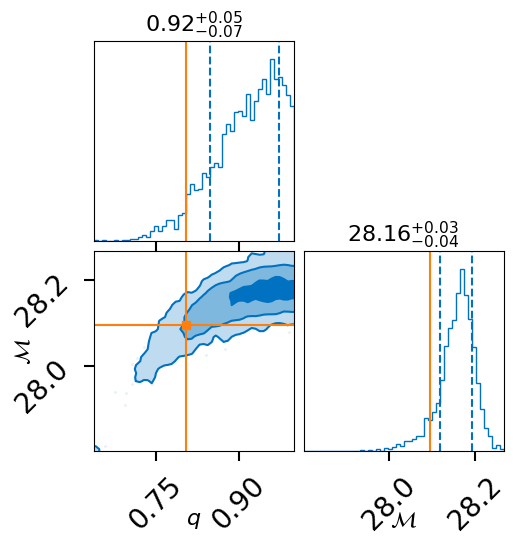

In [5]:
fig = result.plot_corner()
post = result.posterior[['mass_ratio', 'chirp_mass', 'log_prior', 'log_likelihood']]
lnz = result.log_evidence
lnz_err = result.log_evidence_err
fig

In [12]:
print(f"lnZ = {lnz:.2f} +/- {lnz_err:.2f}")
print(f"lnBF = {result.log_bayes_factor:.2f}")

lnZ = -1984.29 +/- 0.10
lnBF = 70.70


In [19]:
likelihood.parameters.update(injection_parameters)
print(f"LnL: {likelihood.log_likelihood():.2f}")
print(f"Noise LnL: {likelihood.noise_log_likelihood():.2f}")
print(f"LnL-Noise LnL: {likelihood.log_likelihood_ratio():.2f}")

LnL: -1964.89
Noise LnL: -2054.98
LnL- Noise LnL: 90.09


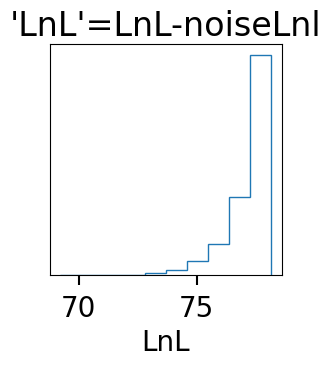

In [28]:
plt.figure(figsize=(3,3))
plt.hist(result.posterior.log_likelihood, histtype='step')
plt.xlabel("LnL")
plt.yticks([])
plt.title("'LnL'=LnL-noiseLnl");

NOTE: the LVK stores the log-likelihood - noise log-likelihood in the column labeled 'log-likelihood'

## Compute FI evidence

In [7]:
lnz_file = f"{OUTDIR}/lnz.npz"
lnzs, r_vals = get_fi_lnz_list(post, num_ref_params=100, cache_fn=lnz_file)

|funnel|INFO| Calculating FI LnZ using a posterior sample of size: (2653, 4) 


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s]

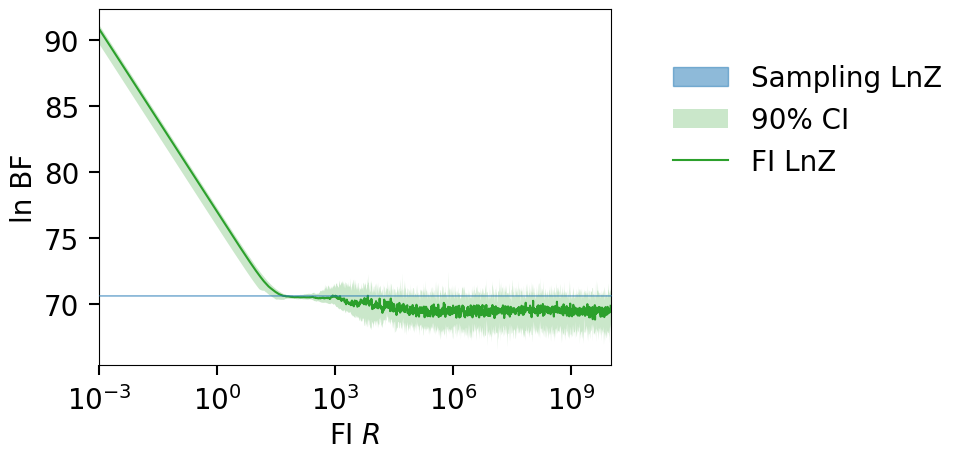

In [30]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals, sampling_lnz=[result.log_bayes_factor])
fig = plot_fi_evidence_results(**plt_kwgs)
fig.tight_layout()
fig.gca().set_ylabel(r"ln BF");

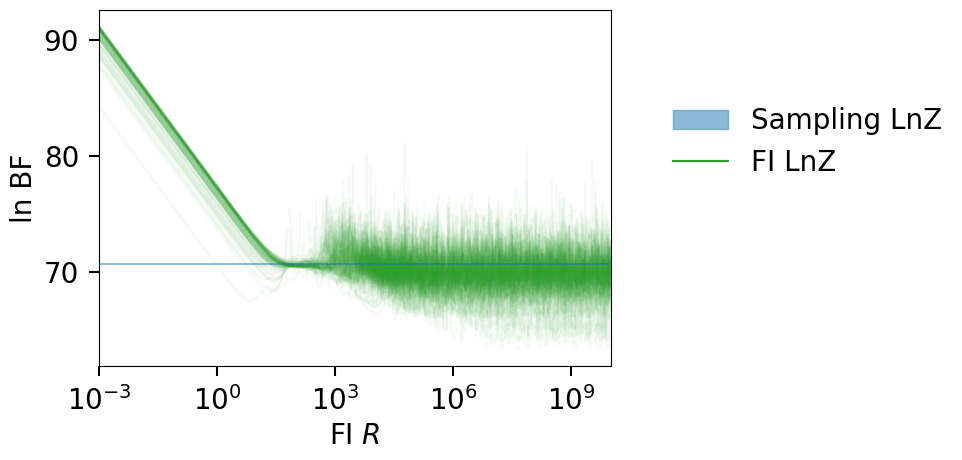

In [31]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_inividual_lnzs=True)
fig.tight_layout()
fig.gca().set_ylabel(r"ln BF");